## Twitter US Airline Sentiment - Problem Statement
#### by Arash Sarhangi Fard

Objective: A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Importing Libraries 

In [162]:
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                    # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

# Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt                         
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (f1_score, accuracy_score, recall_score, precision_score,
    confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, precision_recall_curve, make_scorer,
    cohen_kappa_score, precision_recall_fscore_support )


# loading model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Model 1: XGBoost Model
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.utils import class_weight

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:95%!important;width:auto!important;}</style>"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sarha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Data from AWS Anthena

In [80]:
df=pd.read_csv('Tweets.csv')

## Data exploration

### Data Size and Overview

In [81]:
# size of data
df.shape

(14640, 15)

In [82]:
df.head().T

,0,1,2,3,4
tweet_id,570306133677760513,570301130888122368,570301083672813571,570301031407624196,570300817074462722
airline_sentiment,neutral,positive,neutral,negative,negative
airline_sentiment_confidence,1.0,0.3486,0.6837,1.0,1.0
negativereason,NaN,NaN,NaN,Bad Flight,Can't Tell
negativereason_confidence,NaN,0.0,NaN,0.7033,1.0
airline,Virgin America,Virgin America,Virgin America,Virgin America,Virgin America
airline_sentiment_gold,NaN,NaN,NaN,NaN,NaN
name,cairdin,jnardino,yvonnalynn,jnardino,jnardino
negativereason_gold,NaN,NaN,NaN,NaN,NaN
retweet_count,0,0,0,0,0


column named “airline_sentiment” and how we can predict it based on travelers’ tweets. 

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

There are missing values.

### Missing Values

In [84]:
df.isnull().sum(axis=0)  # Check for NULL values.

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Observation: many missing values in negativereason, negativereason_confidence, airline_sentiment_gold, negativereason_gold, tweet_coord, user_timezone.
Since we do not use them for prediction, then we do nothing with missing values.
Two important columns: 'text' and 'airline_sentiment' do not have a missing value!

### Remove Duplicates  Records

checking duplicates based on tweet_id, name, tweet_created, text (because no user cannot tweet on same id on same time). 
Removing the duplicated records.

In [85]:
df.shape

(14640, 15)

In [86]:
df=df.sort_values('tweet_id').drop_duplicates(subset=['name', 'text','tweet_created'],keep='first',inplace=False)

In [87]:
df.shape

(14485, 15)

Observation: There are 14640-14485= 155 dublicated records! are removed. 

### Data Statistics & EDA

In [88]:
#get the unique values of every column
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [89]:
# Product Category= Software
print(return_unique_values(df))

                        Features  Uniques
0                       tweet_id    14485
1              airline_sentiment        3
2   airline_sentiment_confidence     1018
3                 negativereason       10
4      negativereason_confidence     1402
5                        airline        6
6         airline_sentiment_gold        3
7                           name     7701
8            negativereason_gold       12
9                  retweet_count       18
10                          text    14427
11                   tweet_coord      832
12                 tweet_created    14247
13                tweet_location     3081
14                 user_timezone       85


Important Observations:
1. 3 airline_sentiment.
2. 6 airlines.

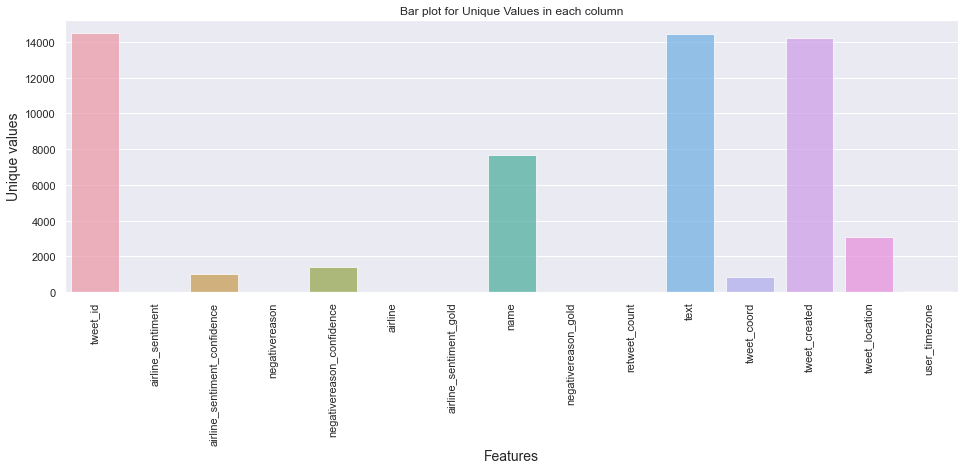

In [90]:
unidf=return_unique_values(df)
# plot the count of unique values in every column
f, ax = plt.subplots(1,1, figsize=(16,5))
sns.barplot(x=unidf['Features'], y=unidf['Uniques'], alpha=0.7)
plt.title('Bar plot for Unique Values in each column')
plt.ylabel('Unique values', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(rotation=90)
plt.show()

* Visual analysis of the number of unique values in every column

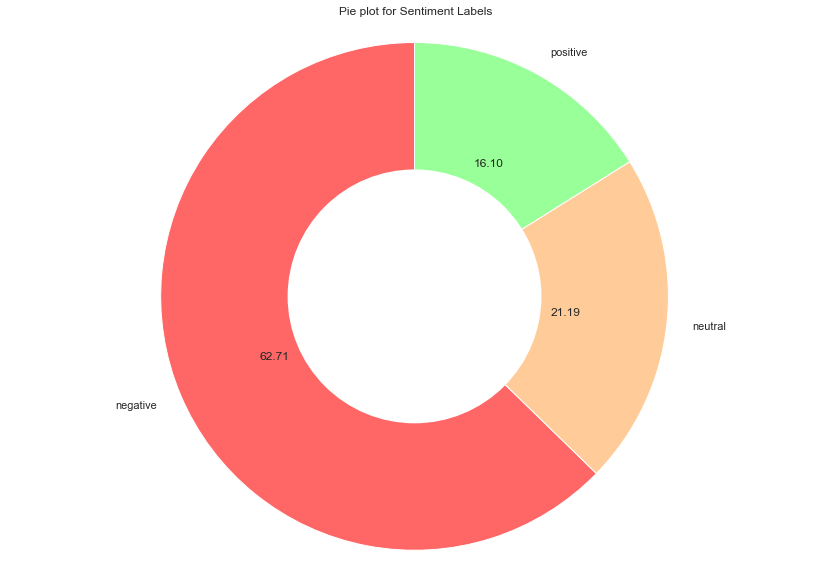

In [91]:
#plot for product category Labels
#Using matplotlib
colors = ['#ff6666', '#ffcc99', '#99ff99']

sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = plt.pie(df['airline_sentiment'].value_counts(), labels=df['airline_sentiment'].value_counts().index, colors=colors, startangle=90,  autopct='%.2f')
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Pie plot for Sentiment Labels')
plt.axis('equal')
plt.tight_layout()
plt.show()

* Most of the sentiment are Negative ** (62.71%),  followed by Neutra; and Positive.

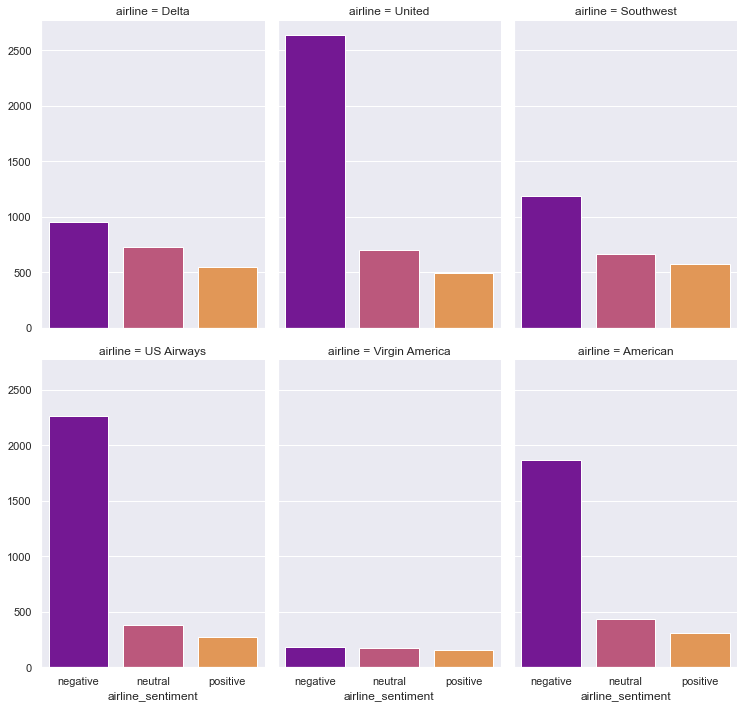

In [92]:
#show sentiments for each airline.
g = sns.FacetGrid(df, col='airline', col_wrap=3, height=5, aspect =0.7) 
g = g.map(sns.countplot, 'airline_sentiment',order =df.airline_sentiment.value_counts().index, palette='plasma') 
plt.show()

Observations:

1.United Airline has more number of negative tweets than neutral and positive combined.It is same for US Airways and American airways.

2.This imbalance is not so bad for Southwest and Delta Airline

3.Virgin America Airline has almost similar number of negative, neutral and positive tweets.

#### Number of tweets for every Airline

Text(0.5, 1.0, 'Number of tweets for every Airline')

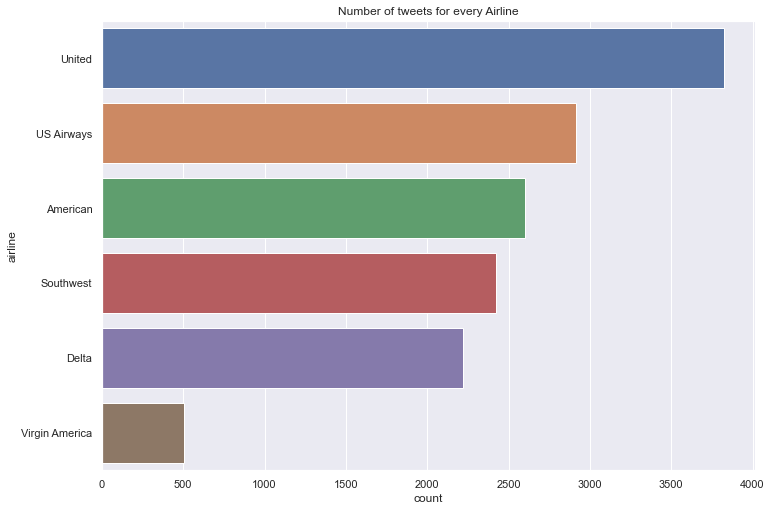

In [93]:
#number of tweets
sns.countplot(data=df,y=df['airline'],order = df['airline'].value_counts().index).set_title('Number of tweets for every Airline')

Observations:
1. United Airline has maximum number of tweets.
2. Virgin America Airline has minimum number of tweets.

#### Distribution of Number of negative tweets for every Airline

Text(0.5, 1.0, 'Percentage wise Distribution of Number of negative tweets for every Airline')

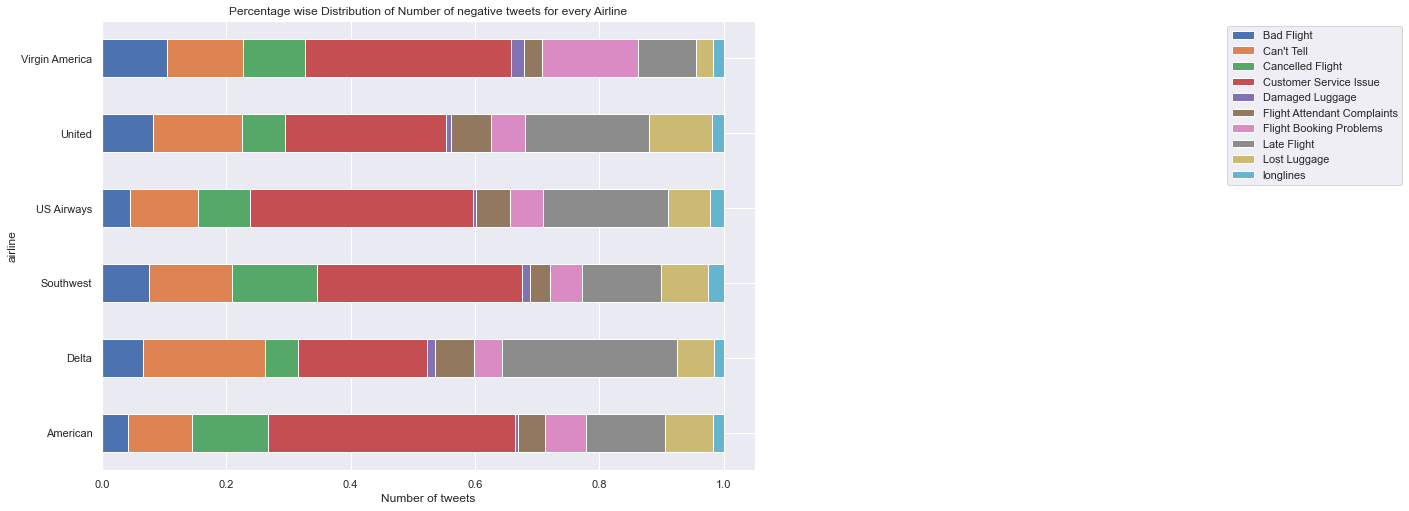

In [94]:
types = df.groupby("airline")['negativereason'].value_counts(normalize=True).unstack()
types.plot(kind='barh', stacked='True')
plt.legend(bbox_to_anchor=(2, 1), loc='upper right')
plt.xlabel('Number of tweets')
plt.title('Percentage wise Distribution of Number of negative tweets for every Airline')


Observations:

1. Delta and united airlines have better customer service than other airlines
2. Virgin America need to seriously introspect when it comes to flight booking problems
3. Your luggage is more safe while traveling with Virgin America
4. Here,We dont have any information about whether we ever get back our lost luggage while traveling.
5. Delta passangers are suffering more from late flights than any other reason. Dont wait for flight to become full. Just take off !!!

#### Locations of Tweeter users on Map

In [95]:
myCord=df['tweet_coord'].dropna().tolist()
Num=re.findall(r"[-+]?\d*\.\d+|\d+", myCord[0])
map1 = folium.Map(location=[Num[0],Num[1]], zoom_start=2)
for i in range(1, len(myCord)):
    Num=re.findall(r"[-+]?\d*\.\d+|\d+", myCord[i])
    folium.Marker([Num[0],Num[1]], icon=folium.Icon(color='red', icon='glyphicon glyphicon-user',size=2)).add_to(map1)
map1

Observations: Maximum number of tweets have come from North America

## Data Pre-processing
* Data preprocessing is a data mining technique that involves transforming raw data into an understandable format. Real-world data is often incomplete, inconsistent, and/or lacking in certain behaviors or trends, and is likely to contain many errors. Data preprocessing is a method to resolve such issues.

**Data Pre-processing steps here:**

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Remove the URL's.
- Remove the mentions in the tweets('@').
- Tokenization.
- To remove Stopwords.
- Remove the punctuations.
- Remove the non-ASCII characters.
- Remove the hashtags.
- Lemmatized data.
- We have used the NLTK library to tokenize words, remove stopwords and lemmatize the remaining words.

In [96]:
df=df.drop(['tweet_coord'],axis=1)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_created,tweet_location,user_timezone
8965,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05 -0800,USA,Sydney
8964,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
4325,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
4324,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
6745,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [97]:
# Remove @ with Airline names
df['text']=df['text'].str.replace('@VirginAmerica','')
df['text']=df['text'].str.replace('@united','')
df['text']=df['text'].str.replace('@SouthwestAir','')
df['text']=df['text'].str.replace('@JetBlue','')
df['text']=df['text'].str.replace('@AmericanAir','')
df['text']=df['text'].str.replace('@USAirways','')
df.head()                                 # Check first 5 rows of data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_created,tweet_location,user_timezone
8965,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,'s new CEO seeks the right balance to please p...,2015-02-16 23:36:05 -0800,USA,Sydney
8964,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,is REALLY getting on my nerves !! 😡😡 #nothappy,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
4325,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,yes. We waited in line for almost an hour to ...,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
4324,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,the we got into the gate at IAH on time and h...,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
6745,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,"its cool that my bags take a bit longer, dont...",2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


### Text Cleaning Process

#### Stopwords

In [98]:
from wordcloud import WordCloud, STOPWORDS
import nltk

# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [99]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the reviews
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def remove_char(text):
    text = re.sub("[^A-Za-z]+"," ",text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_url(text)
    text = remove_mention(text)
    text = remove_char(text)
    return text


In [100]:
# Create a new column for clean text
df['text_clean'] = df['text'].apply(lambda x: clean_text(x))

In [101]:
# drop the original column of text
df=df.drop(['text'],axis=1)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14485 entries, 8965 to 8966
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14485 non-null  int64  
 1   airline_sentiment             14485 non-null  object 
 2   airline_sentiment_confidence  14485 non-null  float64
 3   negativereason                9084 non-null   object 
 4   negativereason_confidence     10413 non-null  float64
 5   airline                       14485 non-null  object 
 6   airline_sentiment_gold        36 non-null     object 
 7   name                          14485 non-null  object 
 8   negativereason_gold           28 non-null     object 
 9   retweet_count                 14485 non-null  int64  
 10  tweet_created                 14485 non-null  object 
 11  tweet_location                9798 non-null   object 
 12  user_timezone                 9710 non-null   object 
 13 

In [103]:
df['text_clean'] = df.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1) # Tokenization of data

In [104]:
lemmatizer = WordNetLemmatizer()

#remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


# Remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# Remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

In [105]:
df['text_clean'] = df.apply(lambda row: normalize(row['text_clean']), axis=1)

In [107]:
df['text_clean'].head()

8965    new ceo seek right balance please passengers w...
8964                            really get nerve nothappy
4325    yes wait line almost hour passengers leave not...
4324    get gate iah time give seat close flight know ...
6745    cool bag take bite longer dont give baggage bl...
Name: text_clean, dtype: object

### Clean Data Visualization (EDA)

#### **Distribution of words for each class**

In [109]:
#get the no of words in every review
df['word_count'] = [len(t.split()) for t in df.text_clean]

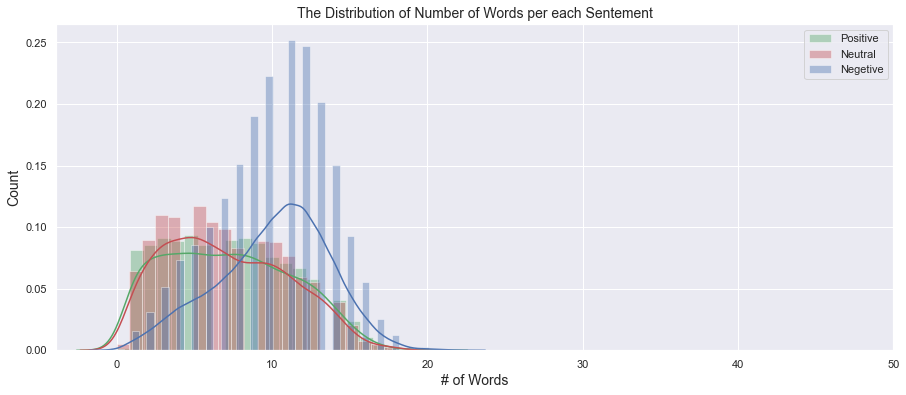

In [113]:
#get the distribution of words for each class
fig = plt.figure(figsize = (15, 6))
sns.distplot(df['word_count'][df['airline_sentiment']=='positive'], color='g', label = 'Positive')
sns.distplot(df['word_count'][df['airline_sentiment']=='neutral'], color='r', label = 'Neutral')
sns.distplot(df['word_count'][df['airline_sentiment']=='negative'], color='b', label = 'Negetive')
plt.legend(loc='best')
plt.xlabel('# of Words', size = 14)
plt.ylabel('Count', size = 14)
plt.xlim(right=50)
plt.title('The Distribution of Number of Words per each Sentement', fontsize = 14)
plt.show()

Observations: 
1. There are outlier tweets in terms of number of words.
2. most of tweets are less 20 words
3. similar distribution between neutral and positive sentements. The negetive sentemnet is different!


#### **Word Cloud for Positive Sentiments**

In [117]:
positive=df[df['airline_sentiment']=='positive']
words = ' '.join(positive['text_clean'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            if ('<br' or '>br' ) not in word
                                and not word.startswith('@')
                                and not word.startswith('<')
                                and not word.startswith('>')
                            ])

In [118]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

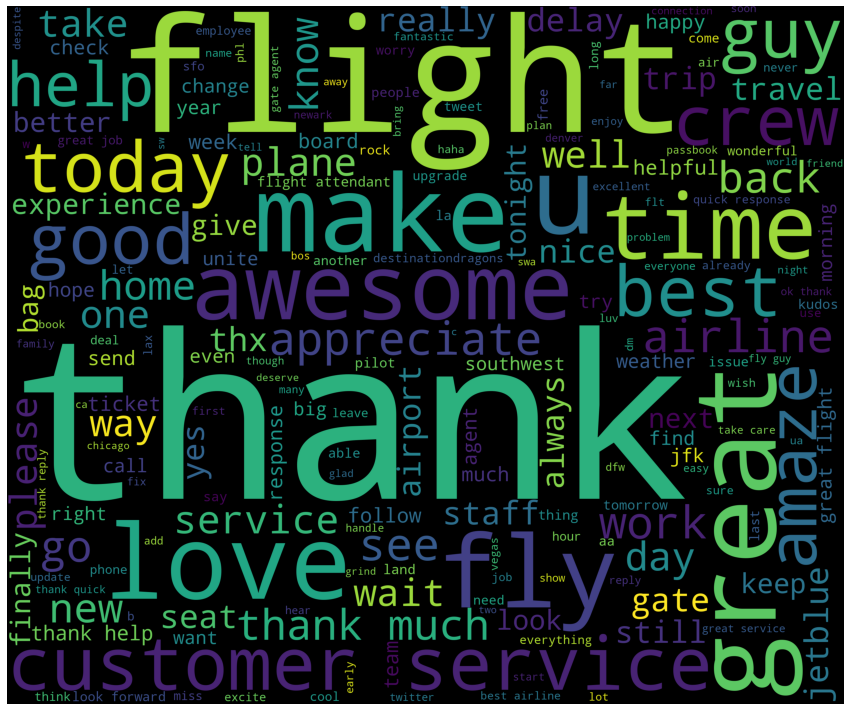

In [119]:
plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Observation: The most repeated words in the reviews for positive category are: flight, awesome, thank, best, help, appreciate, love, great ..

#### **Word Cloud for Neutral Sentiments**

In [120]:
neutral=df[df['airline_sentiment']=='neutral']
words = ' '.join(neutral['text_clean'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            if ('<br' or '>br' ) not in word
                                and not word.startswith('@')
                                and not word.startswith('<')
                                and not word.startswith('>')
                            ])

In [121]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

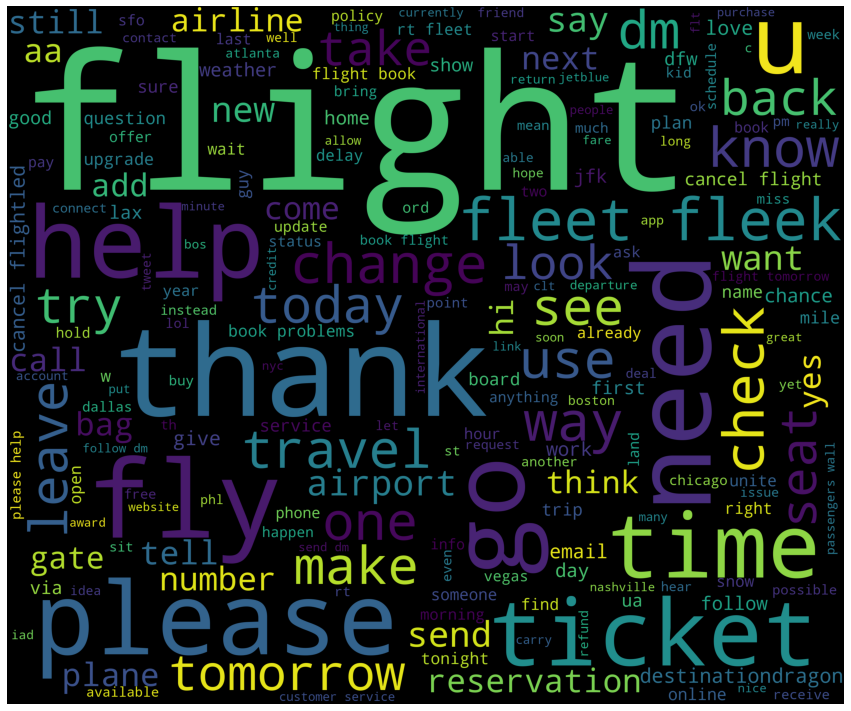

In [122]:
plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Observations:
Most common words which are used in neutral sentiments are: please, thank, need, flight, available, try,..

#### **Word Cloud for Negative Sentiments**

In [125]:
negetive=df[df['airline_sentiment']=='negative']
words = ' '.join(negetive['text_clean'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                            if ('<br' or '>br' ) not in word
                                and not word.startswith('@')
                                and not word.startswith('<')
                                and not word.startswith('>')
                            ])

In [126]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

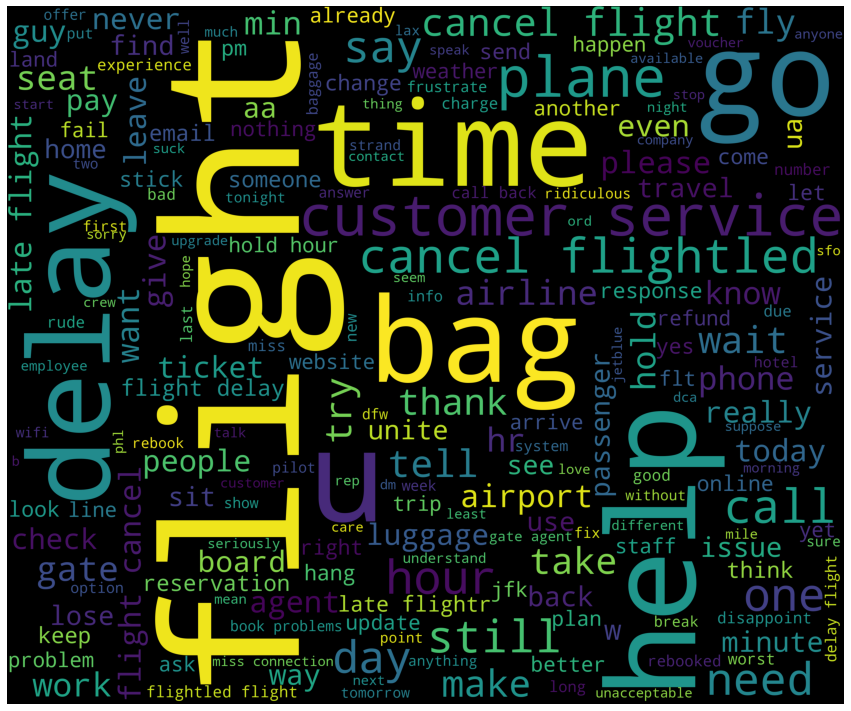

In [127]:
plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Observations:
Most common words which are used in negative sentiments are: delay, cancel, time, seat, problem, wait ..

## Data Formating For Model

In [155]:
## labeling product categoris by number
def category_to_num (category):
    if category=='positive':
        return 0
    if category=='neutral':
        return 1
    if category=='negative':
        return 2
    else:
        return np.nan

## decoding product categoris by number
def num_to_category (category):
    if category==0:
        return 'positive'
    if category==1:
        return 'neutral'
    if category==2:
        return 'negative'
    else:
        return "The Model could not predict the sentiment category!"
    
df['airline_sentiment']=df['airline_sentiment'].apply(category_to_num)

In [156]:
df['airline_sentiment'].value_counts()

Series([], Name: airline_sentiment, dtype: int64)

In [130]:
df.shape

(14485, 15)

In [131]:
# adding texts to a list from panda array
num_reviews=df['text_clean'].size
clean_data_reviews=[]
target=[]
for i in range(0,num_reviews):
    clean_data_reviews.append(df['text_clean'].iloc[i])
    target.append(df['airline_sentiment'].iloc[i])


### Train and Test Split

In [132]:
# stratify: proportion of values in the sample produced will be the same as the proportion of values provided.
x_train, x_test, y_train, y_test = train_test_split(
    clean_data_reviews, target, test_size = 0.2, random_state = 0, stratify=target)

In [136]:
len(x_train), len(x_test), len(y_train), len(y_test)

(11588, 2897, 11588, 2897)

## Model 1: CountVectorizer and XGBoost Model

In [161]:
count_vectorizer = CountVectorizer(max_features=4000)  
train_data_features_model1 = count_vectorizer.fit_transform(x_train)

train_data_features_model1 = train_data_features_model1.toarray()                        # Convert the data features to array.
train_data_features_model1.shape

(11588, 4000)

In [151]:
#Imbalanced Classification Dataset
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train )

In [163]:
# Fit the sorest to the training set, using the tf-idf, and removing constant features

xgb_model1= XGBClassifier( n_estimators=30, num_classes=3, colsample_bytree=0.7, gamma=0.2, subsample=0.7, 
                    n_jobs=-1, eval_metric='mlogloss',sample_weight=classes_weights, verbose_eval=True)


xgb_model1 = xgb_model1.fit(train_data_features_model1, y_train)

print (xgb_model1)

print (np.mean(cross_val_score(xgb_model1, train_data_features_model1 ,y_train ,cv=5)))

[13:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_classes", "sample_weight", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='mlogloss', gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=-1, num_classes=3, num_parallel_tree=1,
              objective='multi:softprob', predic

In [223]:
test_data_features = count_vectorizer.transform(x_test)
test_data_features = test_data_features.toarray()


In [226]:
### Confusion Matrix
y_pred = xgb_model1.predict(test_data_features)
accuracy_model1_xgb_test=accuracy_score(y_test, y_pred)
print('XGBoost Accuracy and CountVectorize on test data: ', accuracy_model1_xgb_test )
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix_model1 = cf_matrix / np.sum(cf_matrix, axis=1)

XGBoost Accuracy and CountVectorize on test data:  0.7670003451846737


Observation : Accuracy of Validation and Test data are similar. No Overfitting! 

<AxesSubplot:>

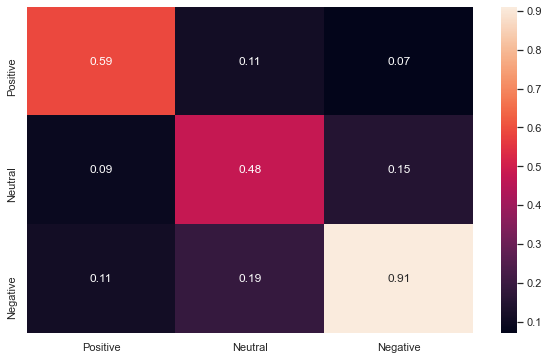

In [227]:
y_labels = ['Positive', 'Neutral', 'Negative' ]
plt.figure(figsize=(10, 6))
sns.heatmap( np.round(cf_matrix_model1, 2), xticklabels=y_labels, yticklabels=y_labels, annot=True)

Observation: Poor Prediction on Neutral. 

In [168]:
import pickle
file_name = "model1_xgb_reg.pkl"

# save
pickle.dump(xgb, open(file_name, "wb"))

## Model 2: TF-IDF and XGBoost Model

### TF-IDF and Dimensionality Reduction

In [170]:
# Initialize the TF-IDF Vectorizer from scikit-learn 
# min_df, max_df, ngram_range are hyperparameters to tune! for dimensionality reduction. 
# max_df: ignore terms that have a document frequency strictly higher than the given threshold.
# min_df: ignore terms that have a document frequency strictly lower than the given threshold.
vectorizer= TfidfVectorizer(min_df=2,max_df=0.5, ngram_range=(1,2), max_features=10000)
#irst fit the model and learning the vocabulary and second it transfroms raining data into vectors.
vectorizer.fit(x_train)
train_data_features = vectorizer.transform(x_train)


In [171]:
print(train_data_features.shape)

(11588, 10000)


Observation: high-dimensionality! and Sparse Matrix.

### Dimensionality Reduction: Feature Selection!

#### filter methods — Remove constant features
Constant features are the features that contain only one value for all the outputs in the dataset. So they can not give us any valuable pieces of information that could help the classifier. Therefore it is much better to remove them.

In [177]:
threshold = 0.00004
constant_filter = VarianceThreshold(threshold)
constant_filter.fit(train_data_features)

VarianceThreshold(threshold=4e-05)

In [178]:
feature_list=[]
for columns in range(train_data_features.shape[1]):
    if constant_filter.get_support()[columns]:
        feature_list.append(vectorizer.get_feature_names()[columns])
    

print('Number of selected features: ' ,len(list(feature_list)),'\n')
print('List of selected features: \n' ,list(feature_list))

Number of selected features:  5556 

List of selected features: 
 ['aa', 'aa customer', 'aa flight', 'aa not', 'aadvantage', 'abc', 'able', 'able dm', 'able get', 'able help', 'aboard', 'abq', 'abroad', 'absolute', 'absolute worst', 'absolutely', 'absurd', 'abt', 'abysmal', 'accept', 'acceptable', 'access', 'accident', 'accommodate', 'accommodations', 'accord', 'accordingly', 'account', 'account help', 'account not', 'accountability', 'acct', 'accurate', 'achieve', 'acknowledge', 'across', 'act', 'act together', 'action', 'actual', 'actually', 'actually care', 'actually flight', 'actually get', 'actually not', 'actually take', 'ad', 'add', 'add flight', 'add ktn', 'add passbook', 'additional', 'address', 'address send', 'admiral', 'admiral club', 'admirals', 'admirals club', 'admit', 'adopt', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisory', 'affect', 'afford', 'afternoon', 'age', 'agency', 'agent', 'agent call', 'agent help', 'agent not', 'agent phone', 'agent say',

We removed 4500 features, which is a considerable number.

In [179]:
x_train_filter = constant_filter.transform(train_data_features)

In [180]:
num_features= x_train_filter.shape[1]
x_train_filter.shape

(11588, 5556)

In [181]:
#Imbalanced Classification Dataset
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train )

In [182]:
# Fit the sorest to the training set, using the tf-idf, and removing constant features

xgb_model2= XGBClassifier( n_estimators=30, num_classes=3, colsample_bytree=0.7, gamma=0.2, subsample=0.7, 
                    n_jobs=-1, eval_metric='mlogloss',sample_weight=classes_weights, verbose_eval=True)


xgb_model2 = xgb_model2.fit(x_train_filter.toarray(), y_train)

print (xgb_model2)

print (np.mean(cross_val_score(xgb_model2, x_train_filter.toarray() ,y_train ,cv=5)))

[13:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_classes", "sample_weight", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='mlogloss', gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=-1, num_classes=3, num_parallel_tree=1,
              objective='multi:softprob', predic

In [183]:
test_data_features = vectorizer.transform(x_test)
x_test_filter = constant_filter.transform(test_data_features)


In [228]:
### Confusion Matrix
y_pred = xgb_model2.predict(x_test_filter.toarray())
accuracy_model2_xgb=accuracy_score(y_test, y_pred)
print('XGBoost/TFIDF Accuracy on test data: ', accuracy_model2_xgb )
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix_model2 = cf_matrix / np.sum(cf_matrix, axis=1)

XGBoost/TFIDF Accuracy on test data:  0.7435277873662409


Observation : Accuracy of Validation and Test data are similar. No Overfitting! 

<AxesSubplot:>

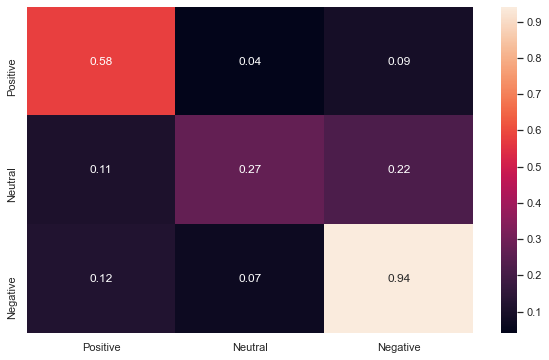

In [229]:
y_labels = ['Positive', 'Neutral', 'Negative' ]
plt.figure(figsize=(10, 6))
sns.heatmap( np.round(cf_matrix_model2, 2), xticklabels=y_labels, yticklabels=y_labels, annot=True)

Observation: Poor Prediction on Neutral. 

In [187]:
import pickle
file_name = "model2_xgb_reg.pkl"

# save
pickle.dump(xgb, open(file_name, "wb"))

##  Deep Learning Models

In [188]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as fds
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [189]:
##create new lists to store sentences and labels
train_sentences = x_train
test_sentences = x_test

train_labels = np.array(y_train)
test_labels = np.array(y_test)


### Data preparation - setting up the tokenizer

In [190]:
##define tokenizing and padding parameters
vocab_size = 10000
max_length = 300
embedding_dim = 128
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


In [191]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type, padding=padding_type)

##testing sequences and labels
test_seqs = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seqs,maxlen=max_length,padding=padding_type, truncating=trunc_type)

In [192]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(train_sentences[1])
print(train_padded[1])

already contact central baggage send dm charge dress lose suitcase help
[ 127  201 1303  104   67   86  193 4058   64 1152   10    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0

### one-hot encoding the class vector

In [193]:
train_labels=to_categorical(train_labels, num_classes=3)
test_labels= to_categorical(test_labels, num_classes=3)

In [194]:
# convert lists into numpy arrays to make it work with TensorFlow 2.x
train_padded = np.array(train_padded)
train_labels = np.array(train_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

### Model3:  Neural Network with Embedding layer

1. Use the Sequential API.
2. Add an embedding input layer of input size equal to vocabulary size.
3. Add a flatten layer, and two dense layers.

In [195]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

##compile the model with loss function, optimizer and metrics
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 1,303,303
Trainable params: 1,303,303
Non-trainable params: 0
_________________________________________________________________


In [196]:
num_epochs = 20
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
mc = ModelCheckpoint(
    "model", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

##train the model with training and validation set
history=model.fit(
    train_padded, 
    train_labels, 
    epochs=num_epochs, 
    callbacks=[es, mc], validation_split=0.1)
#    validation_data=(test_padded, test_labels)


Epoch 1/20
326/326 [==============================] - 9s 25ms/step - loss: 0.9171 - accuracy: 0.6277 - val_loss: 0.9077 - val_accuracy: 0.6083

Epoch 00001: val_accuracy improved from -inf to 0.60828, saving model to model
INFO:tensorflow:Assets written to: model\assets
Epoch 2/20
326/326 [==============================] - 8s 25ms/step - loss: 0.7057 - accuracy: 0.6976 - val_loss: 0.6248 - val_accuracy: 0.7394

Epoch 00002: val_accuracy improved from 0.60828 to 0.73943, saving model to model
INFO:tensorflow:Assets written to: model\assets
Epoch 3/20
326/326 [==============================] - 8s 25ms/step - loss: 0.5643 - accuracy: 0.7662 - val_loss: 0.6121 - val_accuracy: 0.7377

Epoch 00003: val_accuracy did not improve from 0.73943
Epoch 4/20
326/326 [==============================] - 8s 24ms/step - loss: 0.5050 - accuracy: 0.8004 - val_loss: 0.6016 - val_accuracy: 0.7506

Epoch 00004: val_accuracy improved from 0.73943 to 0.75065, saving model to model
INFO:tensorflow:Assets written

In [217]:
### Confusion Matrix

y_test_arg = np.argmax(test_labels, axis=1)
y_pred_drp = np.argmax(model.predict(test_padded), axis=1)
cf_matrix = confusion_matrix(y_test_arg, y_pred_drp)
cf_matrix_model3 = cf_matrix / np.sum(cf_matrix, axis=1)

accuracy_model3=accuracy_score(y_test_arg, y_pred_drp)
print('Neural Netwrok Accuracy on test data: ', accuracy_model3 )


Neural Netwrok Accuracy on test data:  0.7559544356230583


In [218]:
pd.DataFrame(y_test_arg).value_counts()

2    1817
1     614
0     466
dtype: int64

<AxesSubplot:>

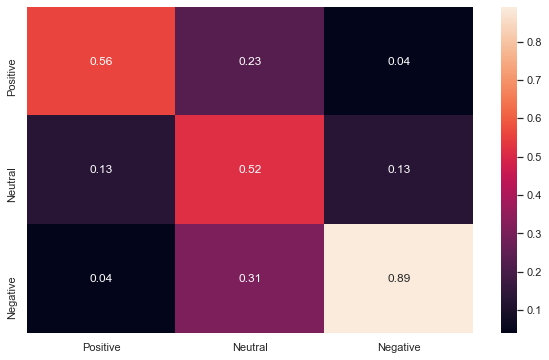

In [219]:
y_labels = ['Positive', 'Neutral', 'Negative' ]
plt.figure(figsize=(10, 6))
sns.heatmap( np.round(cf_matrix_model3, 2), xticklabels=y_labels, yticklabels=y_labels, annot=True)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


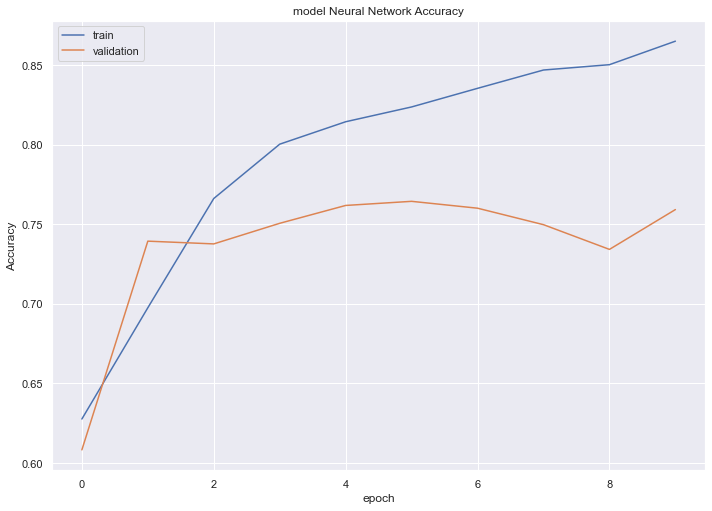

In [200]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model Neural Network Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [215]:
# Average Accuracy on test Data
model3_test=model.evaluate(test_padded, test_labels)

91/91 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.7560


In [216]:
# Average Accuracy on train Data
model3_train=model.evaluate(train_padded, train_labels)

363/363 [==============================] - 1s 2ms/step - loss: 0.3453 - accuracy: 0.8781


In [202]:
model.save('ANN')

INFO:tensorflow:Assets written to: ANN\assets


### Model4:  LSTM Neural Network Network with Embedding layer
•	Initiate the Sequential API.
•	Two bidirectional LSTM layers with 64 and 32 as number of outputs, respectively.
•	1*Dense layer with 50 nodes, and relu as non-linear function.
•	Outer layer with 3 nodes and using the Softmax function to calculate the probability of classes.

In [203]:
model_lstm= tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), #output of LSTM is compatibale with input next LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') ])

##compile the model with loss function, optimizer and metrics
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 128)          1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 1,423,435
Trainable params: 1,423,435
Non-trainable params: 0
_________________________________________________________________


In [204]:
num_epochs = 20
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
mc = ModelCheckpoint(
    "model", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

##train the model with training and validation set
history_lstm=model_lstm.fit(
    train_padded, 
    train_labels, 
    epochs=num_epochs, 
    callbacks=[es, mc], validation_split=0.1, batch_size=64)
#    validation_data=(test_padded, test_labels)


Epoch 1/20
163/163 [==============================] - 191s 1s/step - loss: 0.7085 - accuracy: 0.7077 - val_loss: 0.5619 - val_accuracy: 0.7731

Epoch 00001: val_accuracy improved from -inf to 0.77308, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 2/20
163/163 [==============================] - 167s 1s/step - loss: 0.4427 - accuracy: 0.8309 - val_loss: 0.5535 - val_accuracy: 0.7826

Epoch 00002: val_accuracy improved from 0.77308 to 0.78257, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 3/20
163/163 [==============================] - 196s 1s/step - loss: 0.3259 - accuracy: 0.8823 - val_loss: 0.6095 - val_accuracy: 0.7826

Epoch 00003: val_accuracy did not improve from 0.78257
Epoch 4/20
163/163 [==============================] - 197s 1s/step - loss: 0.2543 - accuracy: 0.9129 - val_loss: 0.6494 - val_accuracy: 0.7619

Epoch 00004: val_accuracy did not improve from 0.78257
Epoch 5/20
163/163 [==============================] - 198s 1s/step - loss: 0.2061 - accuracy: 0.9309 - val_loss: 0.7274 - val_accuracy: 0.7593

Epoch 00005: val_accuracy did not improve from 0.78257
Epoch 6/20
163/163 [==============================] - 197s 1s/step - loss: 0.1660 - accuracy: 0.9456 - val_loss: 0.8253 - val_accuracy: 0.7455

Epoch 00006: val_accuracy did not improve from 0.78257
Epoch 7/20
163/163 [==============================] - 195s 1s/step - loss: 0.1397 - accuracy: 0.9513 - val_loss: 0.8800 - val_accuracy: 0.7489

Epoch 00007: val_accuracy did not improve from 0.78257
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


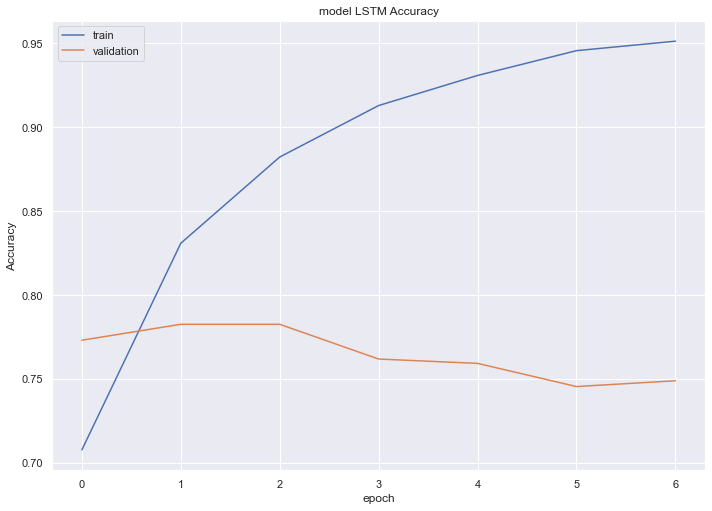

In [220]:
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history["accuracy"])
plt.plot(history_lstm.history['val_accuracy'])
plt.title("model LSTM Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [211]:
### Confusion Matrix

y_test_arg = np.argmax(test_labels, axis=1)
y_pred_drp = np.argmax(model_lstm.predict(test_padded), axis=1)
cf_matrix = confusion_matrix(y_test_arg, y_pred_drp)
cf_matrix_model4 = cf_matrix / np.sum(cf_matrix, axis=1)

accuracy_model4=accuracy_score(y_test_arg, y_pred_drp)
print('LSTM NN Accuracy on test data: ', accuracy_model )

LSTM NN Accuracy on test data:  0.7704521919226787


<AxesSubplot:>

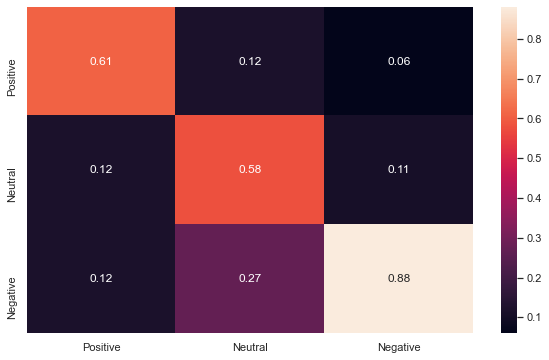

In [212]:
y_labels = ['Positive', 'Neutral', 'Negative' ]
plt.figure(figsize=(10, 6))
sns.heatmap( np.round(cf_matrix_model4, 2), xticklabels=y_labels, yticklabels=y_labels, annot=True)

In [213]:
# Average Accuracy on test Data
model4_test=model_lstm.evaluate(test_padded, test_labels)

91/91 [==============================] - 15s 167ms/step - loss: 0.8384 - accuracy: 0.7705


In [214]:
# Average Accuracy on train Data
model4_train=model_lstm.evaluate(train_padded, train_labels)

363/363 [==============================] - 61s 168ms/step - loss: 0.1839 - accuracy: 0.9469


In [208]:
model_lstm.save('LSTM')

INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


## Conclusion

In [240]:
accu={'accuracy positive':[cf_matrix_model1[0][0], cf_matrix_model2[0][0], cf_matrix_model3[0][0], cf_matrix_model4[0][0]],
      'accuracy neutral': [cf_matrix_model1[1][1], cf_matrix_model2[1][1], cf_matrix_model3[1][1], cf_matrix_model4[1][1]],
      'accuracy negative': [cf_matrix_model1[2][2], cf_matrix_model2[2][2], cf_matrix_model3[2][2], cf_matrix_model4[2][2]]}
model=['XGB CountVectorize', 'XGB TF-IDF', 'ANN', 'LSTM']

In [241]:
eval=pd.DataFrame(accu, model )

In [242]:
eval

,accuracy positive,accuracy neutral,accuracy negative
XGB CountVectorize,0.594421,0.482085,0.907540
XGB TF-IDF,0.583691,0.268730,0.944964
ANN,0.560086,0.521173,0.885526
LSTM,0.613734,0.576547,0.876170


Observations:
1. classifying between positive and neutral sentiments are not easy!
2. classifying negative sentimnets are easire than positive and neutral ones.
3. LSTM model perdict better than other models.